# NLP X - HEC Embeddings Part 2 : Advanced Representations


In this practical session, we will focus on word embeddings through word2vec, a simple and more advanced classification models for sentiment analysis (reviews ratings prediction). Once a negative sampling word2vec skipgram is trained, we can visualize learned word vectors in a reduced space and use them in our classification model.

You will be asked to :
1. **Train your own word embeddings with Skipgram** and Tensorflow using **Negative Sampling** method
2. **Train a sentiment model** using your pre-trained word embeddings as inputs for a simple classification architecture
3. **Upgrade your sentiment model with attention mechanism** through a Hierarchical Attention Network (HAN)
4. **Visualize attention weights** to interpret main sentences and words involved in the prediction


In [ ]:
import io
import os
import re
import tqdm
import warnings
import itertools
from ast import literal_eval

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

import nltk
import sklearn
from sklearn import decomposition
import tensorflow as tf

nltk.download("punkt")
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
tqdm.tqdm_notebook()
tqdm.notebook.tqdm().pandas()

### Data collection and preprocessing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dirpath = "drive/MyDrive/NLP @ X_HEC - 2K21/Cours 4 - Embedding part 2/data/" # change the directory path here
filepath = os.path.join(dirpath, "clean_text_scrapped_data_2021.csv.gz")

DATASET_SIZE = 50000
def get_reviews(nrows=None):
    return pd.read_csv(filepath,
                     #compression='gzip', 
                     low_memory=False, 
                     nrows=nrows,
                     parse_dates=['diner_date', 'rating_date'])


def clean_reviews(reviews):
    reviews['review'] = reviews.content.apply(lambda x: ' '.join(eval(x)))
    return reviews


def split_reviews_per_sentence(reviews):
    reviews["review_sentences"] = reviews.review.progress_apply(
        lambda rvw: nltk.sent_tokenize(rvw)
    )
    return reviews

In [ ]:
reviews = get_reviews(DATASET_SIZE)
reviews.head(2)

,Unnamed: 0,0,answer_text,content,diner_date,id_comment,id_resto,other_ratings_category,other_ratings_value,rating,rating_date,resto,resto_url,reviewer_info_sup,reviewer_origin,reviewer_pseudo,title,url,Day_of_week,clean_content
0,482202,NaN,['We are extreamly sad about your Experiance. ...,['We actually visited this place a few times f...,2017-01-01,g10259438-d11744624-r450260275,g10259438-d11744624,[],[],1.0,2017-01-07,Buns_E17,/Restaurant_Review-g10259438-d11744624-Reviews...,"[['pencil-paper', '11'], ['thumbs-up', '4']]","['London, United Kingdom']",lubix0209,Really disappointing,https://www.tripadvisor.com/ShowUserReviews-g1...,5,"[""'we"", 'actually', 'visited', 'place', 'time'..."
1,482231,NaN,"['Hey gucci Burger', 'Thank you so much for th...",['A blast of warm air greeted us as we entered...,2019-01-01,g10259438-d11744624-r645208007,g10259438-d11744624,[],[],5.0,2019-01-11,Buns_E17,/Restaurant_Review-g10259438-d11744624-Reviews...,"[['pencil-paper', '5'], ['thumbs-up', '1']]","['Chingford, United Kingdom']",Depeche242,Gucci Burgers,https://www.tripadvisor.com/ShowUserReviews-g1...,4,"['blast', 'warm', 'air', 'greeted', 'u', 'ente..."


In [ ]:
df1 = pd.read_csv("drive/MyDrive/NLP @ X_HEC - 2K21/Cours 4 - Embedding part 2/data/Bokan.csv")
df1 = df1.drop(labels='Unnamed: 0', axis=1)
df2 = pd.read_json("drive/MyDrive/NLP @ X_HEC - 2K21/Cours 4 - Embedding part 2/data/SauvegardeFinaleGrade4.json")
reviews = pd.concat([df1, df2])
reviews = reviews.rename(columns={"Review": "content", "Grade": "rating"})
reviews.head()

,Restaurant,Adresse,Rank,Date,Tittle,content,rating,Username,Price,Style
0,Bokan 37 Restaurant,"Floor 37-39, 40 Marsh Wall",#853,"December 30, 2020","“Dinner, Drinks and one heck of a view!”\n",My girlfriend and I enjoyed a fantastic meal a...,5,O3135PCalexh,Indulge and dine amongst industrial dockyard ...,[]
1,Bokan 37 Restaurant,"Floor 37-39, 40 Marsh Wall",#853,"December 12, 2020",“Come here for the evening”\n,Come here for the evening on a date very happy...,5,771maisiej,Indulge and dine amongst industrial dockyard ...,[]
2,Bokan 37 Restaurant,"Floor 37-39, 40 Marsh Wall",#853,"December 12, 2020",“The staff make this place special ”\n,"Lovely ambiance,nicest, most thoughtful staff ...",5,laureninnes90,Indulge and dine amongst industrial dockyard ...,[]
3,Bokan 37 Restaurant,"Floor 37-39, 40 Marsh Wall",#853,"October 24, 2020",“Amazing staff - especially Tatyana”\n,Bokan has been our favorite Saturday spot with...,5,victoriapW4926RH,Indulge and dine amongst industrial dockyard ...,[]
4,Bokan 37 Restaurant,"Floor 37-39, 40 Marsh Wall",#853,"October 18, 2020",“Outstanding service and wonderful”\n,Outstanding service and wonderful food . Loved...,5,Nickkelly55,Indulge and dine amongst industrial dockyard ...,[]


In [ ]:
df1['Date'] = pd.to_datetime(df1['Date'])
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 572 entries, 0 to 571
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Restaurant  572 non-null    object        
 1   Adresse     572 non-null    object        
 2   Rank        572 non-null    object        
 3   Date        572 non-null    datetime64[ns]
 4   Tittle      572 non-null    object        
 5   Review      572 non-null    object        
 6   Grade       572 non-null    int64         
 7   Username    572 non-null    object        
 8   Price       572 non-null    object        
 9   Style       572 non-null    object        
dtypes: datetime64[ns](1), int64(1), object(8)
memory usage: 44.8+ KB


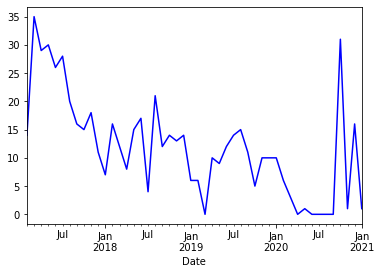

In [ ]:
df1.set_index('Date')['Review'].resample('M').count().plot(color="b")
plt.show()

In [ ]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12866 entries, 0 to 12293
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Restaurant  12866 non-null  object
 1   Adresse     12866 non-null  object
 2   Rank        12866 non-null  object
 3   Date        12866 non-null  object
 4   Tittle      12866 non-null  object
 5   content     12866 non-null  object
 6   rating      12866 non-null  int64 
 7   Username    12866 non-null  object
 8   Price       12866 non-null  object
 9   Style       12866 non-null  object
dtypes: int64(1), object(9)
memory usage: 1.1+ MB


### Preprocessing & Understanding

Let's visualize a review, contained in `content` column, then perform basic cleaning to get a proper text for each review

In [ ]:
reviews.content[0], type(reviews.content[0])

(0    My girlfriend and I enjoyed a fantastic meal a...
 0    For the last 9 years I’ve been working in East...
 Name: content, dtype: object, pandas.core.series.Series)

In [ ]:
#reviews['review'] = reviews.content.apply(lambda x: ' '.join(eval(x)))
reviews["review_sentences"] = reviews.content.progress_apply(
        lambda rvw: nltk.sent_tokenize(rvw)
    )
reviews.head()

,Restaurant,Adresse,Rank,Date,Tittle,content,rating,Username,Price,Style,review_sentences
0,Bokan 37 Restaurant,"Floor 37-39, 40 Marsh Wall",#853,"December 30, 2020","“Dinner, Drinks and one heck of a view!”\n",My girlfriend and I enjoyed a fantastic meal a...,5,O3135PCalexh,Indulge and dine amongst industrial dockyard ...,[],[My girlfriend and I enjoyed a fantastic meal ...
1,Bokan 37 Restaurant,"Floor 37-39, 40 Marsh Wall",#853,"December 12, 2020",“Come here for the evening”\n,Come here for the evening on a date very happy...,5,771maisiej,Indulge and dine amongst industrial dockyard ...,[],[Come here for the evening on a date very happ...
2,Bokan 37 Restaurant,"Floor 37-39, 40 Marsh Wall",#853,"December 12, 2020",“The staff make this place special ”\n,"Lovely ambiance,nicest, most thoughtful staff ...",5,laureninnes90,Indulge and dine amongst industrial dockyard ...,[],"[Lovely ambiance,nicest, most thoughtful staff..."
3,Bokan 37 Restaurant,"Floor 37-39, 40 Marsh Wall",#853,"October 24, 2020",“Amazing staff - especially Tatyana”\n,Bokan has been our favorite Saturday spot with...,5,victoriapW4926RH,Indulge and dine amongst industrial dockyard ...,[],[Bokan has been our favorite Saturday spot wit...
4,Bokan 37 Restaurant,"Floor 37-39, 40 Marsh Wall",#853,"October 18, 2020",“Outstanding service and wonderful”\n,Outstanding service and wonderful food . Loved...,5,Nickkelly55,Indulge and dine amongst industrial dockyard ...,[],"[Outstanding service and wonderful food ., Lov..."


In [ ]:
reviews = clean_reviews(reviews)
reviews.review[0]

SyntaxError: ignored

looks better now ! Now let's split every review by sentence using `sent_tokenize`from `nltk``

For simplicity during this practical session, we will only consider the first *N* reviews. (you can make vary *N*)

In [ ]:
N = 35000
first_reviews = reviews.head(N)
first_reviews.shape

(12866, 11)

In [ ]:
first_reviews

,Restaurant,Adresse,Rank,Date,Tittle,content,rating,Username,Price,Style,review_sentences
0,Bokan 37 Restaurant,"Floor 37-39, 40 Marsh Wall",#853,"December 30, 2020","“Dinner, Drinks and one heck of a view!”\n",My girlfriend and I enjoyed a fantastic meal a...,5,O3135PCalexh,Indulge and dine amongst industrial dockyard ...,[],[My girlfriend and I enjoyed a fantastic meal ...
1,Bokan 37 Restaurant,"Floor 37-39, 40 Marsh Wall",#853,"December 12, 2020",“Come here for the evening”\n,Come here for the evening on a date very happy...,5,771maisiej,Indulge and dine amongst industrial dockyard ...,[],[Come here for the evening on a date very happ...
2,Bokan 37 Restaurant,"Floor 37-39, 40 Marsh Wall",#853,"December 12, 2020",“The staff make this place special ”\n,"Lovely ambiance,nicest, most thoughtful staff ...",5,laureninnes90,Indulge and dine amongst industrial dockyard ...,[],"[Lovely ambiance,nicest, most thoughtful staff..."
3,Bokan 37 Restaurant,"Floor 37-39, 40 Marsh Wall",#853,"October 24, 2020",“Amazing staff - especially Tatyana”\n,Bokan has been our favorite Saturday spot with...,5,victoriapW4926RH,Indulge and dine amongst industrial dockyard ...,[],[Bokan has been our favorite Saturday spot wit...
4,Bokan 37 Restaurant,"Floor 37-39, 40 Marsh Wall",#853,"October 18, 2020",“Outstanding service and wonderful”\n,Outstanding service and wonderful food . Loved...,5,Nickkelly55,Indulge and dine amongst industrial dockyard ...,[],"[Outstanding service and wonderful food ., Lov..."
...,...,...,...,...,...,...,...,...,...,...,...
12289,the Orpington,161 High Street,#1,2018-12-15 00:00:00,“Wow! Yummy mushrooms!”\n,My first visit and it definitely won’t be my l...,5,Sparkyx,€1 - €2,[],[My first visit and it definitely won’t be my ...
12290,the Orpington,161 High Street,#1,2018-12-08 00:00:00,“breakfast”\n,My partner and i popped in for breakfast and h...,5,goldenaxey2k,€1 - €2,[],[My partner and i popped in for breakfast and ...
12291,the Orpington,161 High Street,#1,2018-12-09 00:00:00,“Orpington’s Best Kept Secret!”\n,"Just had breakfast at The Orpington, a new add...",5,MYAJP201,€1 - €2,[],"[Just had breakfast at The Orpington, a new ad..."
12292,the Orpington,161 High Street,#1,2018-12-14 00:00:00,“AMAZING all round”\n,I just popped in for a quick coffee...,5,Neilio F,€1 - €2,[],[I just popped in for a quick coffee...]


**Question** : plot the distribution of ratings. <br>
Rating will be the labels to predict in our classification modeling, so take care to distribution labels to define the good training and evaluation strategies.

Average rating is : 4.71


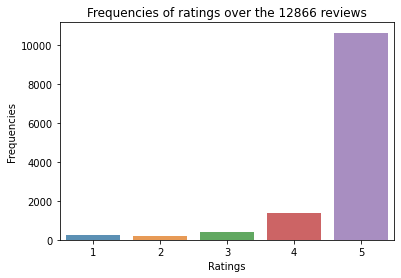

In [ ]:
# Average rating value
print('Average rating is : {}'.format(round(first_reviews.rating.mean(),2)))

# Plotting rating distribution
X_ratings = first_reviews.rating.value_counts()
ax = sns.barplot(X_ratings.index,X_ratings,alpha=0.8)
ax.set(xlabel='Ratings',ylabel='Frequencies',title='Frequencies of ratings over the {} reviews'.format(first_reviews.shape[0]))
plt.show()

In [ ]:
first_reviews["rating"].value_counts() / len(first_reviews)

5    0.827064
4    0.106715
3    0.032877
1    0.017333
2    0.016011
Name: rating, dtype: float64

This dataset is imbalanced, having ~50% of the dataset with rating = 5. The purpose of this notebook is not about validation metrics, but if we were to use accuracy, we should think about remediation strategy (e.g. subsampling the majority class). This imbalance issue could be one of the improvement axis for the homework.


**Question** : plot the distribution of the number of sentences per review. <br>
When handling sequential/textual data, input length may differ from a review to another. In Deep Learning, knowing input length distribution is important to perform zero-padding or truncating processing.

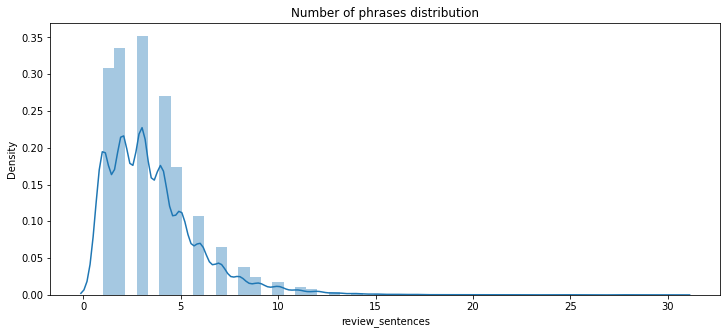

In [ ]:
# Plot density with histogram
x = plt.figure(figsize=(12,5))
sns.distplot(first_reviews["review_sentences"].apply(len))
plt.title('Number of phrases distribution')
plt.show()

In [ ]:
#Create one list with all the sentences from all the list of list with sentences
sentences = list(itertools.chain(*first_reviews["review_sentences"]))
print(f"Number of total sentences : {len(sentences)}")

Number of total sentences : 46458


### Tokenization & Text Encoding
This part concerns tokenization and text encoding with TensorFlow modules :

*(i) Build the token vocabulary* <br>
*(ii) Build a text encoder relying each word to an index, and thus each text to a sequence of word indices* (```list```) <br>
*(iii) Build a TensorFlow dataset for word2vec training*



In [ ]:
# Define and fit tokenizer
tokenizer = tf.keras.preprocessing.text.Tokenizer(filters=' ', char_level=False)
tokenizer.fit_on_texts(sentences)

In [ ]:
sentences[0]

'My girlfriend and I enjoyed a fantastic meal at Bokan, just before Bonfire night.'

**Question** : use *texts_to_sequences* method of our tokenizer to get sequences from sentences.

In [ ]:
sequences = tokenizer.texts_to_sequences(sentences) 
print(first_reviews["review_sentences"][0][0], sentences[0], sequences[0], sep="\n\n")

0    [My girlfriend and I enjoyed a fantastic meal ...
0    [For the last 9 years I’ve been working in Eas...
Name: review_sentences, dtype: object

My girlfriend and I enjoyed a fantastic meal at Bokan, just before Bonfire night.

[20, 756, 2, 8, 116, 3, 102, 74, 33, 3646, 60, 170, 5830, 380]


**Question** : plot the distribution of the number of indices per sequence. <br>
For the same reasons as above, it is important to know length distribution of sentences/sequences.

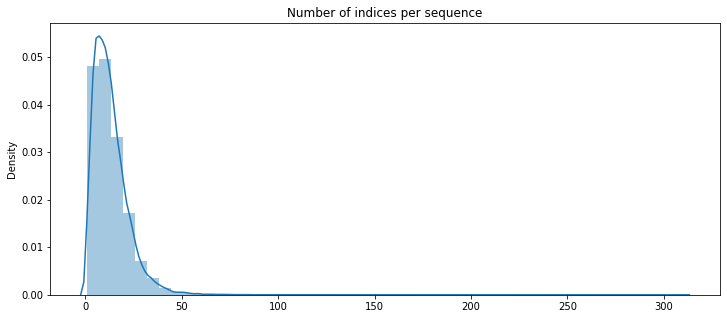

In [ ]:
# Check the distribution of the number of indices per sequence
x = plt.figure(figsize=(12,5))
sns.distplot([len(x) for x in sequences])
plt.title('Number of indices per sequence')
plt.show()

# 1. Train our own word embeddings 

## Negative Sampling Skipgram
Preprocessing function which generates skip-gram pairs with negative sampling for a list of sequences (int-encoded sentences) based on window size, number of negative samples and (tokenizer) vocabulary size.

In [ ]:
max(tokenizer.index_word.keys())

27946

## Generate training data for word2vec

*(i) Define a sampling table for words in vocabulary, see [make_sampling_table](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/make_sampling_table)* <br>
*(ii) For each sequence (tokenized/indexed sentence), run sliding process (window) and appropriate word sampling to build positive skip-gram word pairs* <br>
*(iii) Iterate over each positive skip-gram pair to produce training examples with positive context word and negative samples, building corresponding labels.* <br>
*(iv) Returns overall combinations of (target word, context word, negative words)*

In [ ]:

def generate_training_data(sequences, window_size, num_ns, vocab_size, seed=42):
    # Elements of each training example are appended to these lists.
    targets, contexts, labels = [], [], []

    # Build the sampling table for vocab_size tokens.
    sampling_table = tf.keras.preprocessing.sequence.make_sampling_table(vocab_size)

    # Iterate over all sequences (sentences) in dataset.
    for sequence in tqdm.notebook.tqdm(sequences):

        # Generate positive skip-gram pairs for a sequence (sentence).
        positive_skip_grams, _ = tf.keras.preprocessing.sequence.skipgrams(
            sequence, 
            vocabulary_size=vocab_size,
            sampling_table=sampling_table,
            window_size=window_size,
            negative_samples=0
        )

        # Iterate over each positive skip-gram pair to produce training examples 
        # with positive context word and negative samples.
        for target_word, context_word in positive_skip_grams:
            context_class = tf.expand_dims(tf.constant([context_word], dtype="int64"), 1)
            negative_sampling_candidates, _, _ = tf.random.log_uniform_candidate_sampler(
                true_classes=context_class,
                num_true=1, 
                num_sampled=num_ns, 
                unique=True, 
                range_max=vocab_size, 
                seed=seed, 
                name="negative_sampling"
            )

            # Build context and label vectors (for one target word)
            negative_sampling_candidates = tf.expand_dims(negative_sampling_candidates, 1)

            context = tf.concat([context_class, negative_sampling_candidates], 0)
            label = tf.constant([1] + [0]*num_ns, dtype="int64")

            # Append each element from the training example to global lists.
            targets.append(target_word)
            contexts.append(context)
            labels.append(label)

    return targets, contexts, labels

**Question** : Build training data using ```window_size=2``` and number of negative samples per positive pair ```num_ns=4```. 

In [ ]:
targets, contexts, labels = generate_training_data(
    sequences=sequences, 
    window_size=2, 
    num_ns=4, 
    vocab_size=max(tokenizer.index_word.keys())+1 # vocab size + 1 for padding
)

print(len(targets), len(contexts), len(labels))


332994 332994 332994


In [ ]:
targets[0], contexts[0]

(5830, <tf.Tensor: shape=(5, 1), dtype=int64, numpy=
 array([[  60],
        [ 559],
        [  39],
        [3899],
        [ 147]])>)

## Define TensorFlow dataset
Define valid TensorFlow dataset from targets/contexts/labels iterable objects.
Set two parameters : 
* *BUFFER_SIZE*
* *BATCH_SIZE*

*BATCH_SIZE* can be particularly important for making training efficient. Note that *BATCH_SIZE* must be obviously lower than dataset size.

In [ ]:
#BATCH_SIZE = 1024
#BUFFER_SIZE = 10000

BATCH_SIZE = 64
BUFFER_SIZE = 100

dataset = tf.data.Dataset.from_tensor_slices(((targets, contexts), labels))
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
print(dataset)

<BatchDataset shapes: (((64,), (64, 5, 1)), (64, 5)), types: ((tf.int32, tf.int64), tf.int64)>


Define Skipgram model

In [ ]:
class Skipgram(tf.keras.Model):
    """Negative Sampling Skigpram implementation.

    ```python
    w2v = Skipgram(vocab_size=4096, embedding_dim=128)
    ````
    """
    def __init__(self, vocab_size, embedding_dim):
        """Skigpram class constructor.

        Parameters
        ----------
        vocab_size: int.
            Size of the vocabulary.

        embedding_dim: int.
            Dimension of trained word2vec Skipgram embeddings.

        """
        super(Skipgram, self).__init__()
        self.target_embedding = tf.keras.layers.Embedding(
            vocab_size, 
            embedding_dim,
            input_length=1,
            name="w2v_embedding",
        )
        self.context_embedding = tf.keras.layers.Embedding(
            vocab_size, 
            embedding_dim, 
            input_length=4+1, # number of negative samples = 4
            name="context_embedding",
        ) 
        self.dots = tf.keras.layers.Dot(axes=(3,2))
        self.flatten = tf.keras.layers.Flatten()

    def call(self, pair):
        """Model forward method.
        """
        target, context = pair
        we = self.target_embedding(target)
        ce = self.context_embedding(context)
        dots = self.dots([ce, we])
        
        return self.flatten(dots)

Define objective and training

In [ ]:
embedding_dim = 128

word2vec = Skipgram(vocab_size=max(tokenizer.index_word.keys())+1, embedding_dim=128)
word2vec.compile(
    optimizer="adam",
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)

In [ ]:
word2vec.fit(dataset, epochs=3)

Epoch 1/3
5203/5203 [==============================] - 302s 57ms/step - loss: 1.5436 - accuracy: 0.3080
Epoch 2/3
5203/5203 [==============================] - 300s 58ms/step - loss: 1.2086 - accuracy: 0.5756
Epoch 3/3
5203/5203 [==============================] - 298s 57ms/step - loss: 0.8893 - accuracy: 0.7160


In [ ]:
word2vec.summary()

Model: "skipgram"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
w2v_embedding (Embedding)    multiple                  3577216   
_________________________________________________________________
context_embedding (Embedding multiple                  3577216   
_________________________________________________________________
dot (Dot)                    multiple                  0         
_________________________________________________________________
flatten (Flatten)            multiple                  0         
Total params: 7,154,432
Trainable params: 7,154,432
Non-trainable params: 0
_________________________________________________________________


## Word Embeddings & Visualization

word2vec.summary()

In [ ]:
pretrained_weights = word2vec.get_layer('w2v_embedding').get_weights()[0]
pretrained_weights.shape

(27947, 128)

Let's now visualize the embedding space, in 2 or 3 dimension. We could use a dimensionality reduction method such as PCA, T-SNE or UMAP.

**Question** : after defining PCA object, use *fit_transform* method to get 3D-reduced vectors of word embeddings for visualization and print explained variance ratio.

In [ ]:
def do_pca(pretrained_weights):
    pca = decomposition.PCA(n_components=3)
    reduced_weights = pca.fit_transform(pretrained_weights)
    return pca, reduced_weights

pca, reduced_weights = do_pca(pretrained_weights)
print(reduced_weights.shape)
print(pca.explained_variance_ratio_)

In [ ]:
df_pca = pd.DataFrame(data=reduced_weights, columns=["pca_1", "pca_2", "pca_3"])
df_pca["word"] = ["<pad>"] + list(tokenizer.word_index.keys())

In [ ]:
fig = px.scatter_3d(
    df_pca, 
    x="pca_1", 
    y="pca_2", 
    z="pca_3",
    hover_name="word",
    template="plotly_white"
)
fig.update_layout(height=700, width=700)
fig.show()

**Question** : explore visual representations and similarities of pretrained word2vec embeddings using convenient visualizer. <br>
To get a better 3D representation, we can use the [TensorFlow Embedding Projector](https://projector.tensorflow.org/). To do that, we save word2vec embeddings (*vecs.tsv* + *meta.tsv*) as following to load them in the projector :

In [ ]:
out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')

for idx, word in tokenizer.index_word.items():
    
    vec = pretrained_weights[idx] # first idx is 1 : skip 0, it's padding.
    out_m.write(word + "\n")
    out_v.write('\t'.join([str(x) for x in vec]) + "\n")
    
out_v.close()
out_m.close()

## 2. Train a sentiment model 
### Using your pre trained embeddings train a simple rating Classifier

Our learned word embeddings can be used to represent the words of a text and to build a text representation. This text representation will be useful for classifcation.


In [ ]:
first_reviews["review_sentences"].shape

(12866,)

**Question** : use *join* operator to get single string per review from lists in *review_sentences* column then plot the input length distribution of the sequences (tokenized reviews).

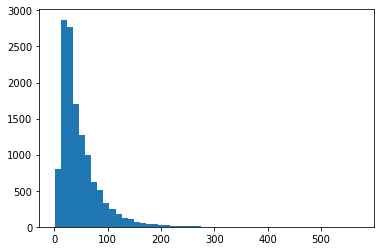

In [ ]:
processed_review = [' '.join(rvw) for rvw in first_reviews["review_sentences"]] ### FILL THE BLANK ###
processed_sequences = tokenizer.texts_to_sequences(processed_review)

plt.hist([len(sequence) for sequence in processed_sequences], bins=50)
plt.show()

In [ ]:
padded_processed_sequences = tf.keras.preprocessing.sequence.pad_sequences(processed_sequences, maxlen=180, padding="post")
padded_processed_sequences.shape

(12866, 180)

In [ ]:
first_reviews.rating.value_counts()

5    10641
4     1373
3      423
1      223
2      206
Name: rating, dtype: int64

In [ ]:
first_reviews['usable_rating'] = first_reviews['rating'].apply(lambda r: int(r)-1)
first_reviews.usable_rating.value_counts()

4    10641
3     1373
2      423
0      223
1      206
Name: usable_rating, dtype: int64

Build datasets

In [ ]:
rating_labels = tf.keras.utils.to_categorical(first_reviews['usable_rating'], num_classes=5, dtype='float32')
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(padded_processed_sequences, rating_labels, test_size=0.3)

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))

train_ds = train_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
test_ds = test_ds.batch(BATCH_SIZE)


**Simple rating Model architecture** is defined by :
1. An embedding layer initialized with pretrained word2vec embeddings.
2. A dense layer without particular activation function for linear projection of the previous embedding vectors.
3. A global average pooling (1D).
4. A final dense layer for linear projection in a $d$-dimensional space for sentiment prediction, with $d$ the number sentiments/classes (here 5).


In [ ]:
simple_rating_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(
        max(tokenizer.index_word.keys())+1, 
        128, 
        embeddings_initializer=tf.keras.initializers.Constant(pretrained_weights), # weights=[pretrained_weights] 
        trainable=True
    ),
    tf.keras.layers.Dense(64),
    tf.keras.layers.GlobalAveragePooling1D(data_format='channels_last'),
    tf.keras.layers.Dense(5)
])

simple_rating_model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    optimizer="adam",
    metrics=["accuracy"]
)

Train model

In [ ]:
simple_history = simple_rating_model.fit(
    train_ds, 
    epochs=20, 
    validation_data=test_ds
)

Epoch 1/20
141/141 [==============================] - 6s 39ms/step - loss: 0.9246 - accuracy: 0.8144 - val_loss: 0.6345 - val_accuracy: 0.8179
Epoch 2/20
141/141 [==============================] - 5s 36ms/step - loss: 0.5994 - accuracy: 0.8287 - val_loss: 0.5986 - val_accuracy: 0.8181
Epoch 3/20
141/141 [==============================] - 5s 36ms/step - loss: 0.5501 - accuracy: 0.8298 - val_loss: 0.5433 - val_accuracy: 0.8228
Epoch 4/20
141/141 [==============================] - 5s 37ms/step - loss: 0.4740 - accuracy: 0.8396 - val_loss: 0.5102 - val_accuracy: 0.8275
Epoch 5/20
141/141 [==============================] - 5s 39ms/step - loss: 0.4111 - accuracy: 0.8564 - val_loss: 0.4984 - val_accuracy: 0.8311
Epoch 6/20
141/141 [==============================] - 5s 37ms/step - loss: 0.3589 - accuracy: 0.8698 - val_loss: 0.5015 - val_accuracy: 0.8264
Epoch 7/20
141/141 [==============================] - 5s 37ms/step - loss: 0.3076 - accuracy: 0.8907 - val_loss: 0.5165 - val_accuracy: 0.8272

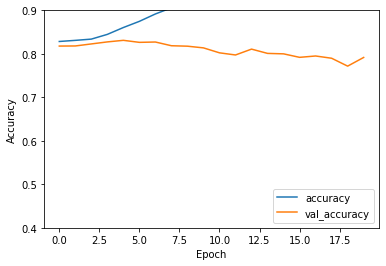

In [ ]:
# history of accuracy 
plt.plot(simple_history.history['accuracy'], label='accuracy')
plt.plot(simple_history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.4, 0.9])
plt.legend(loc='lower right')

In [ ]:
test_loss_simple, test_acc_simple = simple_rating_model.evaluate(X_test,  y_test, verbose=2)
print("The test Accuracy for this first model is :", test_acc_simple)

121/121 - 0s - loss: 1.0969 - accuracy: 0.7917
The test Accuracy for this first model is : 0.791709840297699



## 3. Upgrade your sentiment model with attention mechanism through a Hierarchical Attention Network (HAN)

<img src="https://drive.google.com/uc?id=1Q4H1MlBZ6ZasBCHxlARc25T9mBFRctiy"/>
<ID of image>


Preprocessing

For Hierarchical Attention Network, text preprocessing and inputs differ from the previous method. Here, the input is not just a sequence of all integers corresponding to all words/tokens of the review. Working at a sentence-level, the HAN input is a sequence of sequences (tokenized sentences) of integers. 

Thus, a such architecture needs a particular preprocessing (padding and truncating).

In [ ]:
def review_preprocessing(review, words_maxlen=50, sentences_maxlen=10, tokenizer=tokenizer):
    """Preprocessing function to build appropriate padded sequences for HAN.

    Parameters
    ----------
    review: list.
        List of sentences (strings) of the review.
    
    words_maxlen: int.
        Maximal length/number of words for a sentence.

    sentences_maxlen: int.
        Maximal length/number of sentences for a review.

    Returns
    -------
    padded_sequences: tf.Tensor.
        Tensor of shape (sentences_maxlen, words_maxlen)
    """
    sequences = tokenizer.texts_to_sequences(review)
    padded_sequences = tf.keras.preprocessing.sequence.pad_sequences(sequences, maxlen=words_maxlen, padding="post")

    if padded_sequences.shape[0] < sentences_maxlen:
        padded_sequences = tf.pad(
            padded_sequences, 
            paddings=tf.constant([[0, sentences_maxlen-padded_sequences.shape[0]], [0, 0]])
        )
    elif padded_sequences.shape[0] > sentences_maxlen:
        padded_sequences = padded_sequences[:sentences_maxlen]

    assert padded_sequences.shape == (sentences_maxlen, words_maxlen)
    return padded_sequences

In [ ]:
print(review_preprocessing(first_reviews["review_sentences"][0]).shape)
print(first_reviews["review_sentences"][0])

(10, 50)
0    [My girlfriend and I enjoyed a fantastic meal ...
0    [For the last 9 years I’ve been working in Eas...
Name: review_sentences, dtype: object


In [ ]:
padded_preprocessed_reviews = [review_preprocessing(review) for review in tqdm.notebook.tqdm(first_reviews["review_sentences"])]
padded_preprocessed_reviews = tf.stack(padded_preprocessed_reviews)
padded_preprocessed_reviews.shape

TensorShape([12866, 10, 50])

Build datasets

In [ ]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(padded_preprocessed_reviews.numpy(), rating_labels, test_size=0.3)
print(
    X_train.shape,
    X_test.shape, 
    y_train.shape, 
    y_test.shape,
    sep="\n"
)

(9006, 10, 50)
(3860, 10, 50)
(9006, 5)
(3860, 5)


In [ ]:
#train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
#test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))

train_ds = tf.data.Dataset.from_tensor_slices((padded_preprocessed_reviews.numpy(), rating_labels))

train_ds = train_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
test_ds = test_ds.batch(BATCH_SIZE)

Let's define our Attention Layer

In [ ]:
class Attention(tf.keras.layers.Layer):
    """Attention mechanism used in "Hierarchical Attention Networks for Document Classification" paper.
        
    ```python
    attention_layer = Attention(units=64)
    ```
    """
    def __init__(self, units):
        """Attention layer constructor.

        Parameters
        ----------
        units: int.
            Dimension of the projection space.
        """
        super(Attention, self).__init__()
        self.W = tf.keras.layers.Dense(units)
        self.u = tf.keras.layers.Dense(1)

    def call(self, sequence):
        """Layer forward method.
        """
        attention_logits = self.u(tf.nn.tanh(self.W(sequence)))
        attention_weights = tf.nn.softmax(attention_logits, axis=-2)

        weighted_vectors = attention_weights * sequence
        context_vector = tf.reduce_sum(weighted_vectors, axis=-2)

        return context_vector, attention_weights

In [ ]:
batch1 = tf.random.normal((16, 10, 50, 128))
batch2 = tf.random.normal((16, 10, 128))

attention = Attention(units=64)

(att_batch1, weights_batch1), (att_batch2, weights_batch2) = attention(batch1), attention(batch2)
print(att_batch1.shape, weights_batch1.shape)
print(att_batch2.shape, weights_batch2.shape)

(16, 10, 128) (16, 10, 50, 1)
(16, 128) (16, 10, 1)


**Hierarchical Attention Network architecture** is defined by:

1. An embedding layer initialized with pretrained word2vec embeddings.
2. A sentence encoder : a Bidirectional GRU coupled with an Attention process run on words embeddings.
3. A document/review encoder : a Bidirectional GRU coupled with an Attention process run on sentence encoder outputs.
4. A final dense layer for linear projection in a $d$-dimensional space for sentiment prediction, with $d$ the number of possible sentiments/classes.


In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [ ]:
import datetime
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [ ]:
class HierarchicalAttentionNetwork(tf.keras.Model):
    """Hierarchical Attention Network implementation.

    Reference :
    * Hierarchical Attention Networks for Document Classification : https://www.cs.cmu.edu/~./hovy/papers/16HLT-hierarchical-attention-networks.pdf

    """
    def __init__(self, vocab_size, embedding_dim, gru_units, attention_units, classifier_units, pretrained_weights=None):
        """Hierarchical Attention Network class constructor.

        """
        super(HierarchicalAttentionNetwork, self).__init__()
        
        if pretrained_weights is not None:
            initializer = tf.keras.initializers.Constant(pretrained_weights)
        else:
            initializer = "uniform"

        self.embedding = tf.keras.layers.Embedding(
            vocab_size, 
            embedding_dim, 
            embeddings_initializer=initializer,
            trainable=True
        )
        self.WordGRU = tf.keras.layers.Bidirectional(
            tf.keras.layers.GRU(
                units=gru_units,
                activation="tanh",
                return_sequences=True
            ), 
            merge_mode='concat',
        )
        #Mask layer
        self.Mask = tf.keras.layers.Masking(mask_value=0.)
        self.fc = tf.keras.layers.Dense(units=gru_units)
        self.WordAttention = Attention(units=attention_units)
        self.SentenceGRU = tf.keras.layers.Bidirectional(
            tf.keras.layers.GRU(
                units=gru_units,
                activation="tanh",
                return_sequences=True
            ), 
            merge_mode='concat',
        )
        self.SentenceAttention = Attention(units=attention_units)
        #Dropout layer
        self.dropout = tf.keras.layers.Dropout(0.8)
        #Dense layer with regularization
        self.fc = tf.keras.layers.Dense(units=classifier_units, kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.03, l2=0.02))

    def call(self, x):
        """Model forward method.
        """
        sentences_vectors, _ = self.word_to_sentence_encoder(x)
        document_vector, _ = self.sentence_to_document_encoder(sentences_vectors)
        return self.fc(document_vector)

    def word_to_sentence_encoder(self, x):
        """Given words from each sentences, 
           encode the contextual representation of the words from the sentence
           with Bidirectional GRU and Attention, and output a sentence_vector
        """
        x = self.embedding(x)
        x = tf.keras.layers.TimeDistributed(self.WordGRU)(x)
        context_vector, attention_weights = self.WordAttention(x)

        return context_vector, attention_weights
    
    def sentence_to_document_encoder(self, sentences_vectors):
        sentences_vectors = self.SentenceGRU(sentences_vectors)
        document_vector, attention_weights = self.SentenceAttention(sentences_vectors)
        return document_vector, attention_weights

In [ ]:
han_model = HierarchicalAttentionNetwork(
    vocab_size=max(tokenizer.index_word.keys())+1, 
    embedding_dim=128, 
    pretrained_weights=pretrained_weights, 
    gru_units=32, 
    attention_units=32, 
    classifier_units=5
)

In [ ]:
han_model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    optimizer="adam",
    metrics=['accuracy']
)

In [ ]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau()

han_history = han_model.fit(
    train_ds, 
    epochs=10, 
    #validation_data=test_ds,
    callbacks=[reduce_lr, tensorboard_callback]
)

Epoch 1/10
202/202 [==============================] - 55s 252ms/step - loss: 2.0347 - accuracy: 0.7847
Epoch 2/10
202/202 [==============================] - 49s 242ms/step - loss: 0.9512 - accuracy: 0.7852
Epoch 3/10
202/202 [==============================] - 50s 246ms/step - loss: 0.7901 - accuracy: 0.7919
Epoch 4/10
202/202 [==============================] - 49s 242ms/step - loss: 0.7123 - accuracy: 0.8117
Epoch 5/10
202/202 [==============================] - 49s 242ms/step - loss: 0.6403 - accuracy: 0.8366
Epoch 6/10
202/202 [==============================] - 50s 245ms/step - loss: 0.5876 - accuracy: 0.8530
Epoch 7/10
202/202 [==============================] - 49s 245ms/step - loss: 0.5575 - accuracy: 0.8638
Epoch 8/10
202/202 [==============================] - 49s 242ms/step - loss: 0.5311 - accuracy: 0.8686
Epoch 9/10
202/202 [==============================] - 49s 241ms/step - loss: 0.5052 - accuracy: 0.8781
Epoch 10/10
202/202 [==============================] - 49s 243ms/step - l

In [ ]:
%tensorboard --logdir logs/fit

*Conclusion* :
* The simple model is a good baseline
* HAN model is much more heavy, with stronger and powerful learning capabilities for training data, involving overfitting risk. Thus it needs regularization (e.g. dropout for instance) for generalization.

## Some improvements for hands-on and homework
**Consider some (1 or 2) of these suggestions to improve HAN performances** :
* Regularization for generalization : dropout, recurrent dropout, L2/L1 regularization
* Address unbalacanced data problems : 
  * For training : oversampling, subsampling, loss weighting, new loss function ?
  * For evaluation : consider other metrics than accuracy : precision, recall, f1-score, confusion matrix...
* Aggressive padding strategy : introduce masking ?
* Iterate with more data, including more validation data

**Model imporvement in our model** 

We had all the improvement in the previous model

*   We had L2/L1 regularization.
*   We had a mask.
*   We had some dropout layers.
*   We iterate with more data, including more validation data.
*   We had a reduce on plateau for the optimizer.

In fine we improved our model a bit, nevertheless it take a lot more time to run. 

For the vizualisation we had a tensor board.




# 4. Visualize attention weights to interpet main sentences and words involved in the prediction 

**Question** : add a new ```document_encoder``` method in HierarchicalAttentionNetwork model which output the document vector and attention weights (sentences weighting) from preprocessed review to determine the most importance sentences.

**Bonus** : get word attention weights for each sentence of a review to show the important words of important sentences.



In [ ]:
reverse_word_map = dict(map(reversed, tokenizer.word_index.items()))
print(sequences[0])
print([reverse_word_map[k] for k in sequences[0]])

[20, 756, 2, 8, 116, 3, 102, 74, 33, 3646, 60, 170, 5830, 380]
['my', 'girlfriend', 'and', 'i', 'enjoyed', 'a', 'fantastic', 'meal', 'at', 'bokan,', 'just', 'before', 'bonfire', 'night.']


In [ ]:
padded_preprocessed_reviews.shape

TensorShape([12866, 10, 50])

In [ ]:
X_test = padded_preprocessed_reviews.numpy()

context_vector, attention_weights = han_model.word_to_sentence_encoder(X_test[:600])
document_vector, attention_weights2 = han_model.sentence_to_document_encoder(context_vector)

In [ ]:
df1[460:461]

,Restaurant,Adresse,Rank,Date,Tittle,Review,Grade,Username,Price,Style
460,Bokan 37 Restaurant,"Floor 37-39, 40 Marsh Wall",#853,2017-04-12,“Great view but slow motion service ”\n,"I just had drinks, which were ok. The view is ...",3,haibane,Indulge and dine amongst industrial dockyard ...,[]


In [ ]:
#We replace k by the sentence we are interessted in 
k = 460

phrase0 = X_test[k].tolist()
phrase0 = [[x for x in test if x!=0] for test in phrase0]
phrase0 = [x for x in phrase0 if x]
phrase0_transformed = [[reverse_word_map[k] for k in phrase] for phrase in phrase0]

#Let's have a look to the full review 
[' '.join(x) for x in phrase0_transformed] 

['i just had drinks, which were ok.',
 'the view is great and the venue has a modern "steam punk" vibe.',
 'the service is so slow in almost unbelievable... even when it is not crowded.',
 "good place if you are not in a rush and you don't want to drink much."]

[['phrase 1', 0.016141387],
 ['phrase 2', 0.12333113],
 ['phrase 3', 0.8564205],
 ['phrase 4', 0.0019625528],
 ['phrase 5', 0.00038440694],
 ['phrase 6', 0.0004174901],
 ['phrase 7', 0.0004430987],
 ['phrase 8', 0.0004493013],
 ['phrase 9', 0.00043120337],
 ['phrase 10', 1.8919502e-05]]

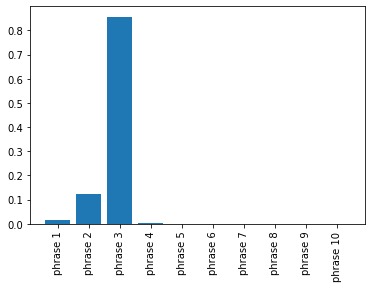

In [ ]:
#Sentence analysis

idx_phr = ['phrase '+ str(x+1) for x in range(10)]

poids_phr = attention_weights2[k].numpy().squeeze()
zipped_phr = [list(t) for t in zip(idx_phr, poids_phr)]

plt.xticks(rotation='vertical')
plt.bar(idx_phr, poids_phr)

zipped_phr

[[0.6749, 'slow'],
 [0.0982, 'so'],
 [0.0953, 'unbelievable...'],
 [0.0839, 'almost'],
 [0.0298, 'is'],
 [0.0071, 'service'],
 [0.0043, 'in'],
 [0.0021, 'not'],
 [0.0008, 'is'],
 [0.0007, 'the'],
 [0.0004, 'when'],
 [0.0004, 'it'],
 [0.0004, 'crowded.'],
 [0.0003, 'even']]

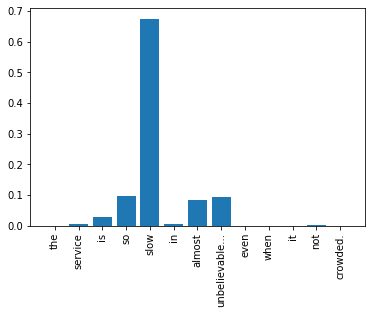

In [ ]:
#word analysis

#We can also change the precise sentence to analyse
sentence_nb = 2

phrase0 = X_test[k].tolist()
phrase0 = [[x for x in test if x!=0] for test in phrase0]
phrase0 = [x for x in phrase0 if x]
phrase0_transformed = [[reverse_word_map[k] for k in phrase] for phrase in phrase0]


poids0 = attention_weights[k][sentence_nb].numpy().squeeze()
poids0 = np.round(poids0, 4)

long = len(phrase0_transformed[sentence_nb])
zipped = [list(t) for t in zip(poids0[:long], phrase0_transformed[sentence_nb])]

plt.xticks(rotation='vertical')
plt.bar(phrase0_transformed[sentence_nb], poids0[:long])

zipped.sort(key=lambda x: x[0], reverse=True)
zipped

Thanks to those nice barplots, we can have a good interpretation of the most important sentences in the review and the most important words in each sentence.

For this precise example we can see that the 4th sentence (3rd according to our notation), is the most important according to our model. Indeed, when we have a look at it we can see several very positive adjectif. And we have a closer look to the world in it, the world that give the most information seems to the the positive adjectives. 